In [59]:
import os
import sys
import re
import string
import glob
import joblib
import pandas as pd

from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

output_dir = "../data/sentiment140"
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"


sys.path.append(os.path.abspath('..'))
from text_processing_utils import preprocess_text

In [60]:
# Use glob to get a list of CSV files in the directory
csv_files = glob.glob(f'{output_dir}/*.csv')

# Now, csv_files contains a list of paths to all CSV files in the directory
for csv_file in csv_files:
    print(csv_file)

../data/sentiment140/debug16000.csv
../data/sentiment140/debug1600.csv
../data/sentiment140/training.1600000.processed.noemoticon.csv
../data/sentiment140/debug.csv
../data/sentiment140/debug160000.csv


In [61]:
# Read the CSV file into a DataFrame with the specified encoding and column names
df = pd.read_csv(csv_files[0], encoding=DATASET_ENCODING)

# Display the first few rows of the DataFrame to check the data
df.head(3)


,target,ids,date,flag,user,text
0,4,1957099063,Thu May 28 23:30:53 PDT 2009,NO_QUERY,Dopplertom,@addyx21 My imaginary girlfriend and We Harras...
1,0,2063777023,Sun Jun 07 04:01:58 PDT 2009,NO_QUERY,anapostrero,"hey stephen, i miss you and your undershirt a..."
2,0,1996566132,Mon Jun 01 15:18:05 PDT 2009,NO_QUERY,ayaueda,ya no pude ver el zapping zone completo... ashsh


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  16000 non-null  int64 
 1   ids     16000 non-null  int64 
 2   date    16000 non-null  object
 3   flag    16000 non-null  object
 4   user    16000 non-null  object
 5   text    16000 non-null  object
dtypes: int64(2), object(4)
memory usage: 750.1+ KB


In [64]:
df["target"] = df["target"].replace(4, 1)
df['text'] = df['text'].apply(preprocess_text)
df = df[['text', 'target']]

In [65]:
df.head(10)

,text,target
0,imaginary girlfriend harrassing people class lmao,1
1,hey stephen miss undershirt ohso kewl shoe,0
2,ya pude ver el zapping zone completo ashsh,0
3,morning everyone,1
4,heyy watchin hill hope jayde worked everythin ...,1
5,yep london week learning bn delicious turkish ...,1
6,wan na see transformer midnight dayum lol,0
7,well fun getting pool ready intense workout ta...,1
8,gave tom bradley high school student cave demo...,1
9,hour nap mean staying late,1


In [66]:
# Save the preprocessed DataFrame to a CSV file
df.to_csv('../data/preprocessed_df16000.csv', index=False)


In [67]:
# Load the preprocessed DataFrame
df = pd.read_csv('../data/preprocessed_df16000.csv')
# Remove rows with NaN values in the text column
df = df.dropna(how='any', subset=['text'])

# Print the DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 15928 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15928 non-null  object
 1   target  15928 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 373.3+ KB


In [68]:
tweet_df = df.copy()

In [69]:
from sklearn.model_selection import train_test_split

# Split the data into training (95%) and test (5%) sets
X_train, X_test, y_train, y_test = train_test_split(tweet_df['text'], tweet_df['target'], test_size=0.25, random_state=42)

In [9]:
display(len(X_train))
display(len(X_test))
display(len(y_train))
display(len(y_test))

12000

4000

12000

4000

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print('No. of feature_words: ', len(tfidf_vectorizer.get_feature_names_out()))

# Save the vectorizer to a file
joblib.dump(tfidf_vectorizer, '../models/tfidf_vectorizer.pkl')

No. of feature_words:  15190


['../models/tfidf_vectorizer.pkl']

In [71]:
import mlflow

# Check if the experiment exists, and if not, create it
experiment_name = "logistic_regression"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/notebooks/mlruns/933793910151989371', creation_time=1695932502553, experiment_id='933793910151989371', last_update_time=1695932502553, lifecycle_stage='active', name='logistic_regression', tags={}>

In [72]:
mlflow.start_run(description="lr model")

<ActiveRun: >

In [73]:
import time
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create a Logistic Regression model
model = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
# Measure the time elapsed for training
start_time = time.time()
model.fit(X_train_tfidf, y_train)
training_time = time.time() - start_time
joblib.dump(model, '../models/logistic_model.pkl')

# Log training time as a parameter
mlflow.log_param("Training_Time", training_time)
# Make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test_tfidf)
prediction_time = time.time() - start_time
# Log prediction time as a parameter
mlflow.log_param("Prediction_Time", prediction_time)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results including training and prediction times
print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Training Time: 1.18 seconds
Prediction Time: 0.00 seconds
Accuracy: 0.7280261175288799
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1976
           1       0.73      0.74      0.73      2006

    accuracy                           0.73      3982
   macro avg       0.73      0.73      0.73      3982
weighted avg       0.73      0.73      0.73      3982



Training Time: 1.18 seconds
Prediction Time: 0.00 seconds
Accuracy: 0.7280261175288799
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1976
           1       0.73      0.74      0.73      2006

    accuracy                           0.73      3982
   macro avg       0.73      0.73      0.73      3982
weighted avg       0.73      0.73      0.73      3982



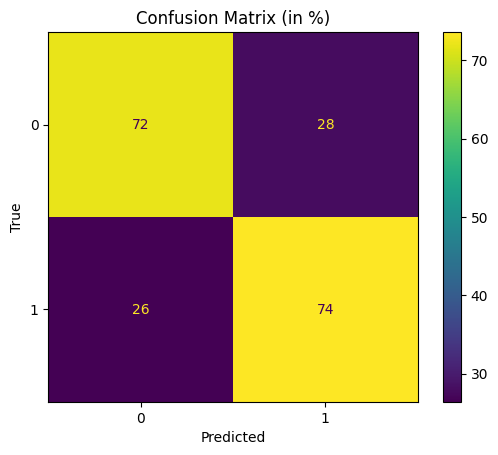

In [74]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results including training and prediction times
print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Normalize the confusion matrix to display percentages
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_norm, display_labels=model.classes_)

# Display the confusion matrix
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (in %)')

# Save the plot as an image (e.g., PNG)
plt.savefig('../imgs/confusion_matrix_plot.png')
mlflow.log_artifact('../imgs/confusion_matrix_plot.png')

# Show the plot
plt.show()


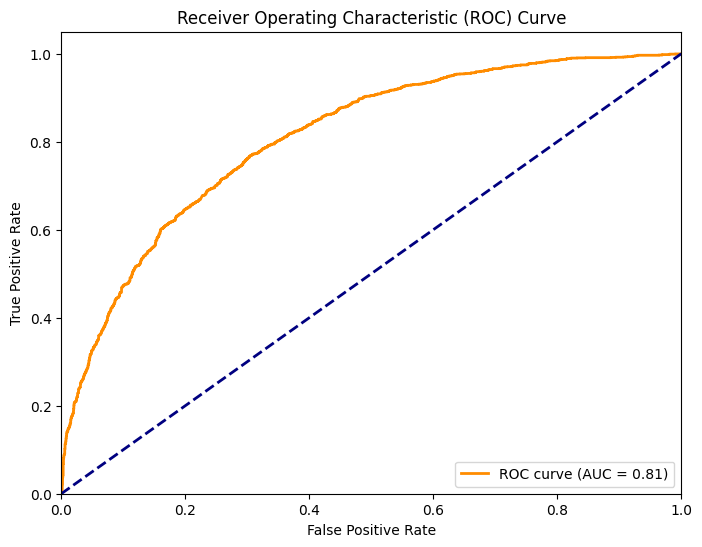

In [75]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]  # Probability of being positive class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create the ROC AUC plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
# Save the plot as an image (e.g., PNG)
plt.savefig('../imgs/roc_auc_plot.png')
mlflow.log_artifact('../imgs/roc_auc_plot.png')

plt.show()


In [76]:
# Track your experiment with MLflow
mlflow.log_metrics({'accuracy': accuracy})
mlflow.log_metrics({'roc_auc': roc_auc})

In [77]:
# Log hyperparameters
mlflow.log_params({'C': model.C, 'penalty': model.penalty, 'max_iter': model.max_iter, 'n_jobs': model.n_jobs})

In [78]:
# Save the model to a file
mlflow.log_artifact('../models/logistic_model.pkl')

In [79]:
mlflow.end_run()

In [57]:
# !mlflow server
!mlflow ui

/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
[2023-10-04 11:46:24 +0200] [5049] [INFO] Starting gunicorn 21.2.0
[2023-10-04 11:46:24 +0200] [5049] [INFO] Listening at: http://127.0.0.1:5000 (5049)
[2023-10-04 11:46:24 +0200] [5049] [INFO] Using worker: sync
[2023-10-04 11:46:24 +0200] [5050] [INFO] Booting worker with pid: 5050
[2023-10-04 11:46:24 +0200] [5051] [INFO] Booting worker with pid: 5051
[2023-10-04 11:46:24 +020